In [1]:
import cv2
import pandas as pd
import numpy as np
import re
import pickle

TWINS_PATH = '/home/user/data/twins_aligned_dlib'

In [2]:
from tqdm import tqdm as tqdm
import os

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [4]:
def parse_keypoints(keypoints_raw):
    keypoints = []
    for kp_raw in keypoints_raw.split('\n'):
        kp = re.findall(r'\d+', kp_raw)
        assert len(kp)==2
        keypoints.append(list(map(int, kp)))
    return np.array(keypoints)

def get_bbox(keypoints):
    min_x, min_y = keypoints.min(axis=0)
    max_x, max_y = keypoints.max(axis=0)
    
    return [int(x) for x in [min_x, min_y, max_x, max_y]]

In [5]:
def get_relative_images_paths(data_path):
    dir_list = os.listdir(data_path)
    images_list = []
    for dir_ in dir_list:
        dir_content = os.listdir(os.path.join(data_path, dir_))
        images_list += [os.path.join(dir_, name) for name in dir_content if '.jpg' in name]
    return images_list

def make_dirs(src_data_path, dst_data_path):
    dir_list = os.listdir(src_data_path)
    for dir_ in dir_list:
        os.makedirs(os.path.join(dst_data_path, dir_), exist_ok=True)

In [6]:
def imread(path):
    img = cv2.imread(path)
    if img is None:
        print(path)
    return img

def imsave(path, img):
    assert img is not None
    cv2.imwrite(path, img)

def load(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj
    
def dump(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    
def imshow(ax, img):
    '''
    img: cv2 image (B G R)
    '''
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except:
        print(img)
    ax.imshow(img)
    ax.grid(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
def plot_landmarks(ax, landmarks):
    '''
    landmarks: np.ndarray
    '''
    ax.scatter(landmarks[:, 0], landmarks[:, 1], c='r', s=3)
    ax.grid(False)

(4310, 2868, 3)


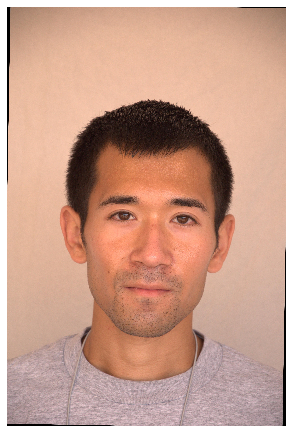

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
img = imread(os.path.join(TWINS_PATH, '90282', '90282d28.jpg'))
imshow(ax, img)
print(img.shape)

In [8]:
df = pd.read_csv(os.path.join(TWINS_PATH, '90282', 'info.csv')).rename(columns={'Unnamed: 0':'img_id'})
images = df.img_id.values
df

img_id  0      1  2      3  \
0  90282d13.jpg -7  front  5     up   
1  90282d28.jpg  2  front  2  front   

                                                   4  
0  [[ 648 2208]\n [ 642 2380]\n [ 671 2552]\n [ 6...  
1  [[ 803 2179]\n [ 797 2363]\n [ 814 2546]\n [ 8...

In [9]:
def get_image_and_landmarks(data_path, image_rel_path, src_landmarks_in_pickle=False):
    idx, img_name = image_rel_path.split('/')
    if src_landmarks_in_pickle:
        landmarks_name = img_name.split('.')[0] + '.landmark'
        landmarks = load(os.path.join(data_path, idx, landmarks_name))
    else:
        df = pd.read_csv(os.path.join(data_path, idx, 'info.csv')).rename(columns={'Unnamed: 0':'img_id'})
        landmarks_raw = df[df['img_id'] == img_name]['4'].iloc[0]
        landmarks = parse_keypoints(landmarks_raw)
    
    img = imread(os.path.join(data_path, image_rel_path))
    return img, landmarks

In [10]:
def save_image_and_landmarks(img, landmarks, data_path, image_rel_path):
    idx, img_name = image_rel_path.split('/')
    landmarks_name = img_name.split('.')[0] + '.landmark'
    imsave(os.path.join(data_path, image_rel_path), img)
    dump(os.path.join(data_path, idx, landmarks_name), landmarks)

(4310, 2868, 3)


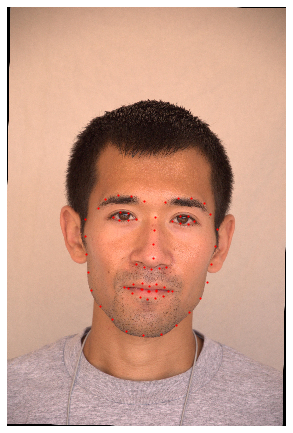

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
img, landmarks = get_image_and_landmarks(TWINS_PATH, '90282/90282d28.jpg')
imshow(ax, img)
plot_landmarks(ax, landmarks)
print(img.shape)

In [12]:
LEFT_EYE_IDXS = [i for i in range(36, 42)]
RIGHT_EYE_IDXS = [i for i in range(42, 48)]

NOSE_BEGINNING = 28
CHIN = 9

FACIAL_LANDMARKS_68_IDXS = dict(
    [("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))]
)

### Define Rotation based on eyes' centers

In [13]:
def get_angle_from_eyes(landmarks):
    left_eye_center = landmarks[LEFT_EYE_IDXS].mean(axis=0).astype(np.int64)
    right_eye_center = landmarks[RIGHT_EYE_IDXS].mean(axis=0).astype(np.int64)
    delta_x = right_eye_center[0] - left_eye_center[0]
    delta_y = right_eye_center[1] - left_eye_center[1]
    alpha = np.arctan(delta_y/delta_x) / np.pi * 180
    return alpha

In [14]:
def rotate_img_landmarks(img, landmarks, angle=0):
    nrows, ncols, _ = img.shape
    M = cv2.getRotationMatrix2D((ncols//2, nrows//2), angle, scale=1)
    img = cv2.warpAffine(img, M, (ncols, nrows))
    assert img is not None
    landmarks = cv2.transform(np.array([landmarks]), M)
    return img, landmarks.squeeze()

3.175


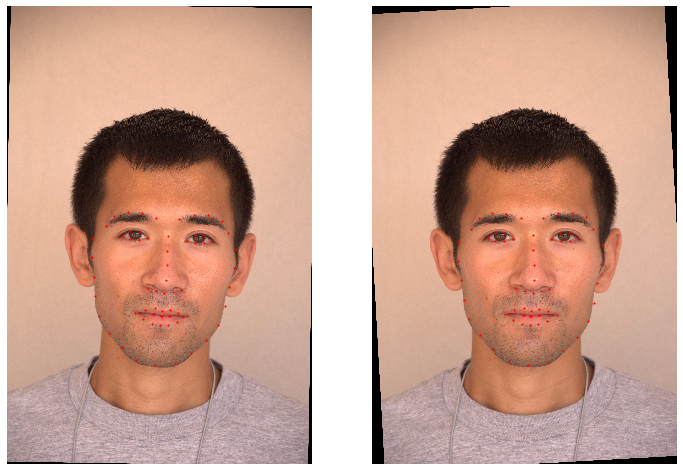

In [15]:
img, landmarks = get_image_and_landmarks(TWINS_PATH, '90282/90282d28.jpg')
#img, landmarks = rotate_img_landmarks(img, landmarks, angle=-20)
angle = get_angle_from_eyes(landmarks)
new_img, new_landmarks = rotate_img_landmarks(img, landmarks, angle=angle)

fig, axs = plt.subplots(1, 2, figsize=(12, 10))
imshow(axs[0], img)
plot_landmarks(axs[0], landmarks)
imshow(axs[1], new_img)
plot_landmarks(axs[1], new_landmarks)
print(f'{angle:.3f}')

##### Define transform

In [16]:
class RotationEyes:
    def __call__(self, img, landmarks):
        angle = get_angle_from_eyes(landmarks)
        new_img, new_landmarks = rotate_img_landmarks(img, landmarks, angle=angle)
        return new_img, new_landmarks

3.175


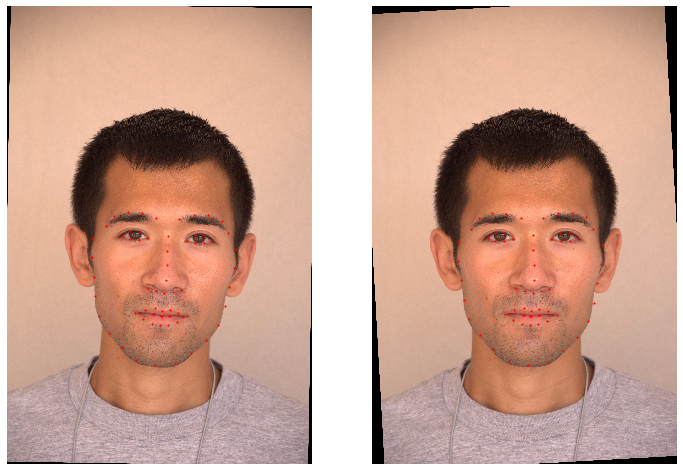

In [17]:
img, landmarks = get_image_and_landmarks(TWINS_PATH, '90282/90282d28.jpg')
#img, landmarks = rotate_img_landmarks(img, landmarks, angle=-20)
transform = RotationEyes()
new_img, new_landmarks = transform(img, landmarks)

fig, axs = plt.subplots(1, 2, figsize=(12, 10))
imshow(axs[0], img)
plot_landmarks(axs[0], landmarks)
imshow(axs[1], new_img)
plot_landmarks(axs[1], new_landmarks)
print(f'{angle:.3f}')

In [18]:
def transform_image(src_data_path, dst_data_path, image_rel_path, transform, src_landmarks_in_pickle=False):
    # load
    img, landmarks = get_image_and_landmarks(src_data_path, image_rel_path, src_landmarks_in_pickle=src_landmarks_in_pickle)
    # transform
    if isinstance(transform, list):
        for tr in transform:
            img, landmarks = tr(img, landmarks)
            new_img, new_landmarks = img, landmarks
    else:
        new_img, new_landmarks = transform(img, landmarks)
    # save
    save_image_and_landmarks(new_img, new_landmarks, dst_data_path, image_rel_path)
    
def transform_all_images(src_data_path, dst_data_path, transform, src_landmarks_in_pickle=False):
    image_list = get_relative_images_paths(src_data_path)
    make_dirs(src_data_path, dst_data_path)
    for image_rel_path in tqdm(image_list):
        transform_image(src_data_path, dst_data_path, image_rel_path, transform, src_landmarks_in_pickle=src_landmarks_in_pickle)

### Define good face-region crop

In [37]:
def crop(img, landmarks, bbox):
    '''
    box: [min_x, min_y, max_x, max_y]
    x - horizontal
    y - vertical
    zero - top left corner
    (from landmarks)
    '''
    min_x, min_y, max_x, max_y = bbox

    if min_x<0:
        max_x-=abs(min_x)
        min_x=0
    if max_x>img.shape[1]:
        min_x+=(max_x-img.shape[1])
        max_x = img.shape[1]
    
    if min_y<0:
        max_y-=abs(min_y)
        min_y=0
    if max_y>img.shape[0]:
        min_y+=(max_y-img.shape[0])
        max_y=img.shape[0]
        
    new_img = img[min_y:max_y, min_x:max_x]
    new_landmarks = landmarks - np.array([min_x, min_y])
    return new_img, new_landmarks

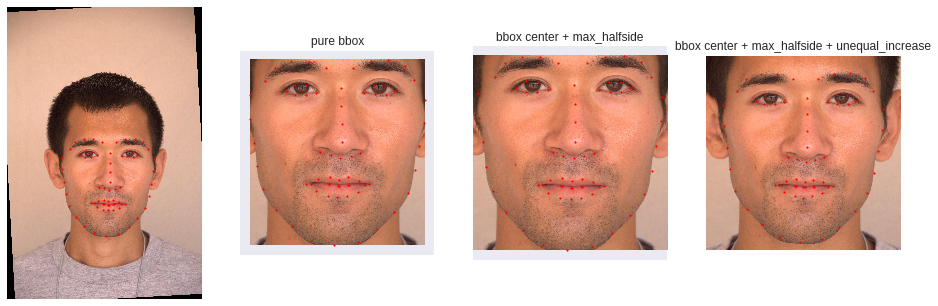

In [20]:
img, landmarks = get_image_and_landmarks(TWINS_PATH, '90282/90282d28.jpg')
rotation_transform = RotationEyes()
img, landmarks = rotation_transform(img, landmarks)

# optimal crop parameters
# pure bbox
bbox = get_bbox(landmarks)
min_x, min_y, max_x, max_y = bbox
crop_box = (min_x, min_y, max_x, max_y)
new_img_1, new_landmarks_1 = crop(img, landmarks, crop_box)

# bbox center + max_halfside
bbox_y = max_y - min_y
bbox_x = max_x - min_x

bbox_center_x = (max_x + min_x) // 2
bbox_center_y = (max_y + min_y) // 2

bbox_rect_halfside = max(bbox_x, bbox_y) // 2
mix_x_new = bbox_center_x - bbox_rect_halfside
min_y_new = bbox_center_y - bbox_rect_halfside
max_x_new = bbox_center_x + bbox_rect_halfside
max_y_new = bbox_center_y + bbox_rect_halfside

crop_box = (mix_x_new, min_y_new, max_x_new, max_y_new)
new_img_2, new_landmarks_2 = crop(img, landmarks, crop_box)

# bbox center + max_halfside + unequal_increase
bbox_y = max_y - min_y
bbox_x = max_x - min_x

bbox_center_x = (max_x + min_x) // 2
bbox_center_y = (max_y + min_y) // 2

bbox_rect_halfside = max(bbox_x, bbox_y) // 2
mix_x_new = bbox_center_x - int(bbox_rect_halfside * 1.15)
min_y_new = bbox_center_y - int(bbox_rect_halfside * 1.2)
max_x_new = bbox_center_x + int(bbox_rect_halfside * 1.15)
max_y_new = bbox_center_y + int(bbox_rect_halfside * 1.1)

crop_box = (mix_x_new, min_y_new, max_x_new, max_y_new)
new_img_3, new_landmarks_3 = crop(img, landmarks, crop_box)

# visualize
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
imshow(axs[0], img)
plot_landmarks(axs[0], landmarks)
axs[1].set_title('pure bbox')
imshow(axs[1], new_img_1)
plot_landmarks(axs[1], new_landmarks_1)
axs[2].set_title('bbox center + max_halfside')
imshow(axs[2], new_img_2)
plot_landmarks(axs[2], new_landmarks_2)
axs[3].set_title('bbox center + max_halfside + unequal_increase')
imshow(axs[3], new_img_3)
plot_landmarks(axs[3], new_landmarks_3)

##### Define transform

In [21]:
class CenterRectCrop:
    def __init__(self, coef_up=1.2, coef_down=1.1, coef_left=1.15, coef_righ=1.15):
        self.coef_up = coef_up
        self.coef_down = coef_down
        self.coef_left = coef_left
        self.coef_righ = coef_righ
    
    def __call__(self, img, landmarks):
        bbox = get_bbox(landmarks)
        min_x, min_y, max_x, max_y = bbox

        bbox_center_x = (max_x + min_x) // 2
        bbox_center_y = (max_y + min_y) // 2
        bbox_rect_halfside = max(bbox_x, bbox_y) // 2
        
        mix_x_new = bbox_center_x - int(bbox_rect_halfside * self.coef_left)
        min_y_new = bbox_center_y - int(bbox_rect_halfside * self.coef_down)
        max_x_new = bbox_center_x + int(bbox_rect_halfside * self.coef_righ)
        max_y_new = bbox_center_y + int(bbox_rect_halfside * self.coef_up)

        crop_box = (mix_x_new, min_y_new, max_x_new, max_y_new)
        new_img, new_landmarks = crop(img, landmarks, crop_box)
        return new_img, new_landmarks

### Test all pipeline

In [36]:
img_crop

array([], shape=(2584, 0, 3), dtype=uint8)

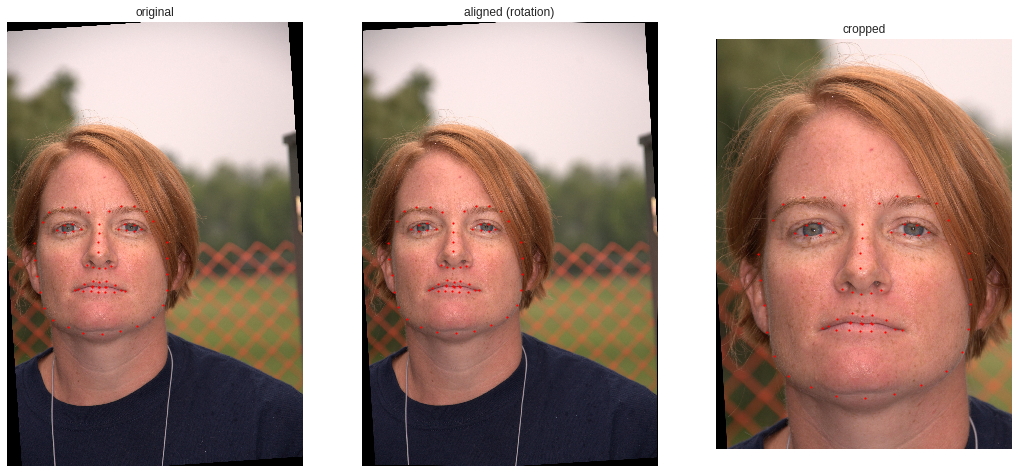

In [41]:
img, landmarks = get_image_and_landmarks(TWINS_PATH, '90062/90062d22.jpg')
#img, landmarks = rotate_img_landmarks(img, landmarks, angle=-20)
transform1 = RotationEyes()
transform2 = CenterRectCrop(coef_up=1.3, coef_down=2.2, coef_left=1.4, coef_righ=1.4)
img_align, landmarks_align = transform1(img, landmarks)
img_crop, landmarks_crop = transform2(img_align, landmarks_align)

fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].set_title('original')
imshow(axs[0], img)
plot_landmarks(axs[0], landmarks)
axs[1].set_title('aligned (rotation)')
imshow(axs[1], img_align)
plot_landmarks(axs[1], landmarks_align)
axs[2].set_title('cropped')
imshow(axs[2], img_crop)
plot_landmarks(axs[2], landmarks_crop)

## Transform images using eyes' centers based rotation

In [24]:
SRC_DATA_PATH = '/home/user/data/twins_aligned_dlib'
DST_DATA_PATH = '/home/user/data/twins_aligned_dlib_eyes_rotation'

In [42]:
transform = [RotationEyes(), CenterRectCrop(coef_up=1.3, coef_down=2.2, coef_left=1.4, coef_righ=1.4)]
transform_all_images(SRC_DATA_PATH, DST_DATA_PATH, transform, src_landmarks_in_pickle=False)


  9%|▉         | 152/1651 [00:28<04:30,  5.54it/s]


 18%|█▊        | 303/1651 [00:56<04:10,  5.37it/s]


 27%|██▋       | 454/1651 [01:23<03:41,  5.40it/s]


 37%|███▋      | 605/1651 [01:51<03:16,  5.33it/s]


 46%|████▌     | 756/1651 [02:19<02:45,  5.40it/s]


 55%|█████▍    | 907/1651 [02:47<02:16,  5.47it/s]


 64%|██████▍   | 1057/1651 [03:15<01:47,  5.52it/s]


 73%|███████▎  | 1205/1651 [03:42<01:23,  5.37it/s]


 82%|████████▏ | 1353/1651 [04:10<00:54,  5.48it/s]


 91%|█████████ | 1501/1651 [04:37<00:26,  5.64it/s]


100%|█████████▉| 1649/1651 [05:04<00:00,  5.42it/s]


100%|██████████| 1651/1651 [05:05<00:00,  5.35it/s]

In [43]:
def show_random_images(data_path):
    img_list = get_relative_images_paths(data_path)
    fig, axs = plt.subplots(3, 6, figsize=(20, 12))
    axs = axs.flatten()
    for i in range(3*6):
        idx = np.random.randint(len(img_list))
        img, landmarks = get_image_and_landmarks(data_path, img_list[idx], src_landmarks_in_pickle=True)
        imshow(axs[i], img)
        plot_landmarks(axs[i], landmarks)

In [44]:
img_list = get_relative_images_paths(DST_DATA_PATH)

In [45]:

fails = []
for img_path in tqdm(img_list):
    img = imread(os.path.join(DST_DATA_PATH, img_path))
    if img is None:
        print(img_path)
        fails.append(img_path)


 27%|██▋       | 446/1651 [00:21<00:57, 21.11it/s]


 54%|█████▍    | 899/1651 [00:42<00:35, 21.31it/s]


 82%|████████▏ | 1346/1651 [01:03<00:14, 21.68it/s]


100%|██████████| 1651/1651 [01:17<00:00, 21.22it/s]

In [46]:
fails

[]

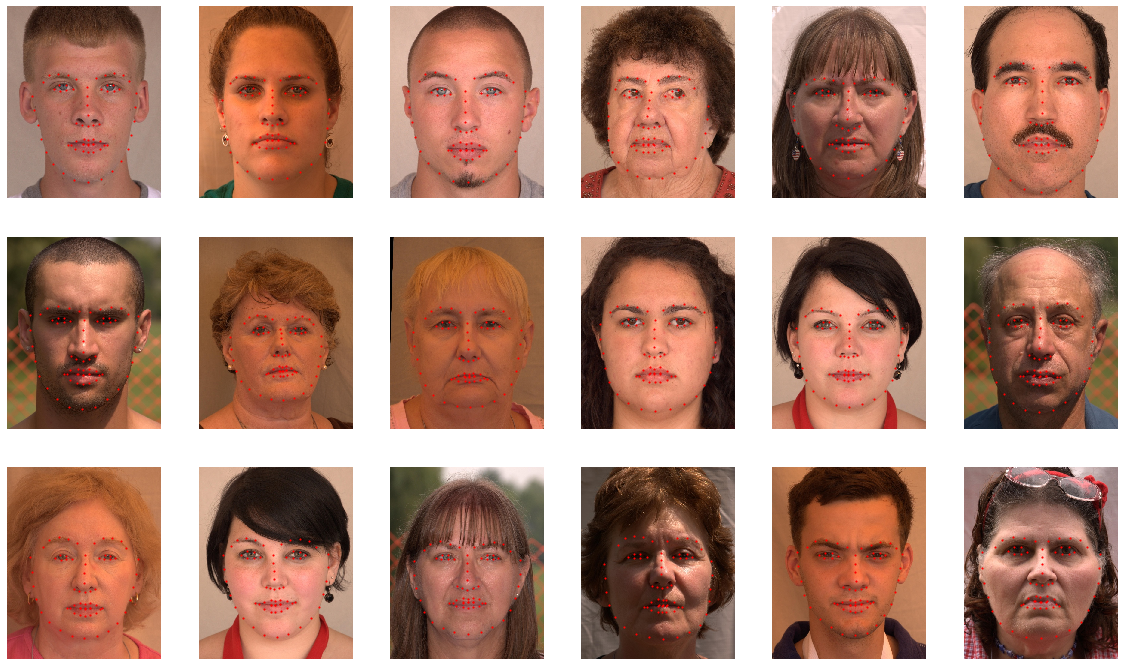

In [69]:
show_random_images(PATH_RESIZED)

In [48]:
img = imread('/home/user/data/twins_aligned_dlib_eyes_rotation/90062/90062d22.jpg')

In [49]:
img.shape

(2512, 1810, 3)

In [50]:
img, landmarks = get_image_and_landmarks('/home/user/data/twins_aligned_dlib_eyes_rotation', '90062/90062d22.jpg', src_landmarks_in_pickle=True)

In [52]:
landmarks.shape

(68, 2)

In [55]:
def get_croped_img(path, img_id, target_size=512):
    img, landmarks = get_image_and_landmarks(path, img_id, src_landmarks_in_pickle=True)
    
    if target_size:
        ratio = target_size/min(img.shape[:2])
        img = cv2.resize(img, (0,0), fx=ratio, fy=ratio)
        landmarks=landmarks*ratio
    return img, landmarks

In [61]:
PATH_RESIZED = '/home/user/data/twins_aligned_eyes_resized'

In [65]:
os.makedirs(PATH_RESIZED)

In [67]:
images[0]

'90308/90308d18.jpg'

In [68]:
images = get_relative_images_paths(DST_DATA_PATH)
for img_path in tqdm(images):
    img, landmarks = get_croped_img(DST_DATA_PATH, img_path)
    os.makedirs(os.path.join(PATH_RESIZED, img_path.split('/')[0]), exist_ok=True)
    save_image_and_landmarks(img, landmarks, PATH_RESIZED, img_path)


 18%|█▊        | 305/1651 [00:16<01:12, 18.60it/s]


 37%|███▋      | 614/1651 [00:33<00:55, 18.64it/s]


 56%|█████▌    | 921/1651 [00:49<00:39, 18.53it/s]


 74%|███████▍  | 1221/1651 [01:05<00:22, 18.75it/s]


 92%|█████████▏| 1523/1651 [01:22<00:06, 19.54it/s]


100%|██████████| 1651/1651 [01:28<00:00, 18.55it/s]

In [56]:
img, landmarks=  get_croped_img(DST_DATA_PATH,'90062/90062d22.jpg')

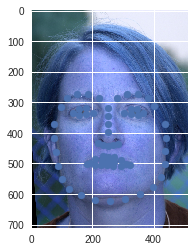

In [60]:
plt.imshow(img)
plt.scatter(landmarks[:,0], landmarks[:,1])

In [ ]:
save_image_and_landmarks